In [10]:
import gymnasium as gym
import flappy_bird_gymnasium
import numpy as np
from Policies import DiscretePolicy, ContinousPolicy
from CommunicationSchemes import ESCommunicationScheme, ESPCCommunicationScheme
from UpdateSchemes import ESMomentum, ESAdam
from utils import parameters_to_vector, vector_to_parameters
import pickle

In [63]:
## Hyperparameters
hidden_size = 8
num_layers = 4
learning_rate = 0.01
l2 = 0.005
sigma = 0.05

## Training setup
save = True
discount_factor = 0.999
ennnvs = ["CartPole"]#, "BipedalWalker", "HalfCheetah", "MountainCar", "MountainCarContinuous", "FlappyBird"]
for ennn in ennnvs:
    experiment_name = f"{ennn}Direct_2"
    num_episodes = 200
    num_runs = 3
    numbers_of_agents = [50]
    # algorithms = [[ESPCCommunicationScheme(50,25,5)for _ in range(50)],[ESCommunicationScheme() for _ in range(50)],[ESCommunicationScheme() for _ in range(25)]]
    numbers_of_agents = [50,50,25]
    algorithms = [[ESPCCommunicationScheme(50,25,5) for _ in range(50)], [ESCommunicationScheme() for _ in range(50)], [ESCommunicationScheme() for _ in range(25)]]
    environments = {"Ant":("Ant-v4", 27, 8, False), "CartPole":("CartPole-v1",4,2,True),"FrozenLake":("FrozenLake-v1",1,4,True), "BipedalWalker":("BipedalWalker-v3",24,4,False), "HalfCheetah":("HalfCheetah-v4",17,6, False), "MountainCar":("MountainCar-v0",2,3,True), "MountainCarContinuous":("MountainCarContinuous-v0",2,1,False), "FlappyBird":("FlappyBird-v0",12,2,True)}
    envName, input_size, output_size, discrete = environments[ennn]
    if discrete:
        policy = DiscretePolicy(input_size,output_size)
    else:
        policy = ContinousPolicy(input_size,output_size)



    ## Initialization
    num_parameters = input_size*hidden_size + input_size +  np.sum(np.fromiter((hidden_size*hidden_size + hidden_size for _ in range(num_layers-2)), dtype=int))+ hidden_size*output_size + output_size
    update_scheme = ESAdam(learning_rate, sigma, num_parameters)

    parameters = np.zeros((num_parameters,1))

    parameter_shapes = [((hidden_size, input_size), (hidden_size,1))]
    parameter_shapes.extend([((hidden_size, hidden_size),(hidden_size,1)) for _ in range(num_layers-3)])
    parameter_shapes.append(((output_size, hidden_size), (output_size,1)))
    parameter_shapes = tuple(parameter_shapes)


    ## Training
    trial_rewards = []
    trial_comms = []
    for k in range(num_runs):
        print(f"Starting trial: {k}")
        algorithmic_rewards = []
        algorithmic_comms = []
        for num_agents, comm_schemes in zip(numbers_of_agents, algorithms):
            print(f"Starting training on {ennn}\n             ")
            env = gym.vector.make(envName, num_envs=num_agents)
            episodic_rewards = []
            episodic_comms = []
            for i in range(num_episodes):
                print(f"Episode: {i}/{num_episodes}", end="\r")
                perturbations = [np.random.normal(0,1,(num_parameters,1)) for _ in range(num_agents)]    
                perturbed_params = [parameters + sigma*perturbation for perturbation in perturbations]
                cum_rewards = np.zeros(num_agents)
                cum_comms = np.zeros(num_agents)
                finished_agents = np.zeros(num_agents, dtype='bool')
                observations, _ = env.reset()
                discount = 1
                while not all(finished_agents):
                    actions = [np.array(policy.act(np.array(observation, dtype=np.float32), perturbed_param, parameter_shapes)) if not finished else 0 if discrete else np.zeros(output_size) for observation, perturbed_param, finished in zip(observations, perturbed_params, finished_agents)]
                    observations, rewards, termination, truncation, infos = env.step(actions)
                    rewards = [discount*reward if not finished else 0 for reward, finished in zip(rewards,finished_agents)]
                    discount *= discount_factor
                    cum_rewards += rewards
                    finished_agents = finished_agents | termination | truncation

                communicated_rewards, communicated_perturbations = [], []
                for perturbation, cum_reward, comm_scheme in zip(perturbations, cum_rewards, comm_schemes):
                    if comm_scheme.doCommunicate(perturbation, cum_reward):
                        communicated_rewards.append(cum_reward)
                        communicated_perturbations.append(perturbation)

                parameters = update_scheme.update(communicated_rewards, communicated_perturbations, parameters)
                episodic_rewards.append(cum_rewards)
                episodic_comms.append(len(communicated_rewards))
            algorithmic_rewards.append(np.mean(episodic_rewards, axis=1))
            algorithmic_comms.append(episodic_comms)
        trial_rewards.append(algorithmic_rewards)
        trial_comms.append(algorithmic_comms)
        
    if save:
        data = [trial_rewards, trial_comms,(hidden_size, num_layers, learning_rate, l2, sigma, discount_factor)]
        with open(f'Results/{experiment_name}.pkl', 'wb') as outp:
            pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)


Starting trial: 0
Starting training on CartPole
             
Starting training on CartPole
             


In [8]:
# with open('Results/CartPoleComm_2.pkl', 'rb') as f:
#     CP1 = pickle.load(f)
# with open('Results/CartPoleComm_ES_2.pkl', 'rb') as f:
#     CP2 = pickle.load(f)

# trial_rewards = np.array(CP1[0])
# trial_comms = np.array(CP1[1])
# ES_rewards = np.array(CP2[0])
# ES_comms = np.array(CP2[1])

# trial_rewards[:,4,:] = ES_rewards[:,0,:]
# trial_comms[:,4,:] = ES_comms[:,0,:]

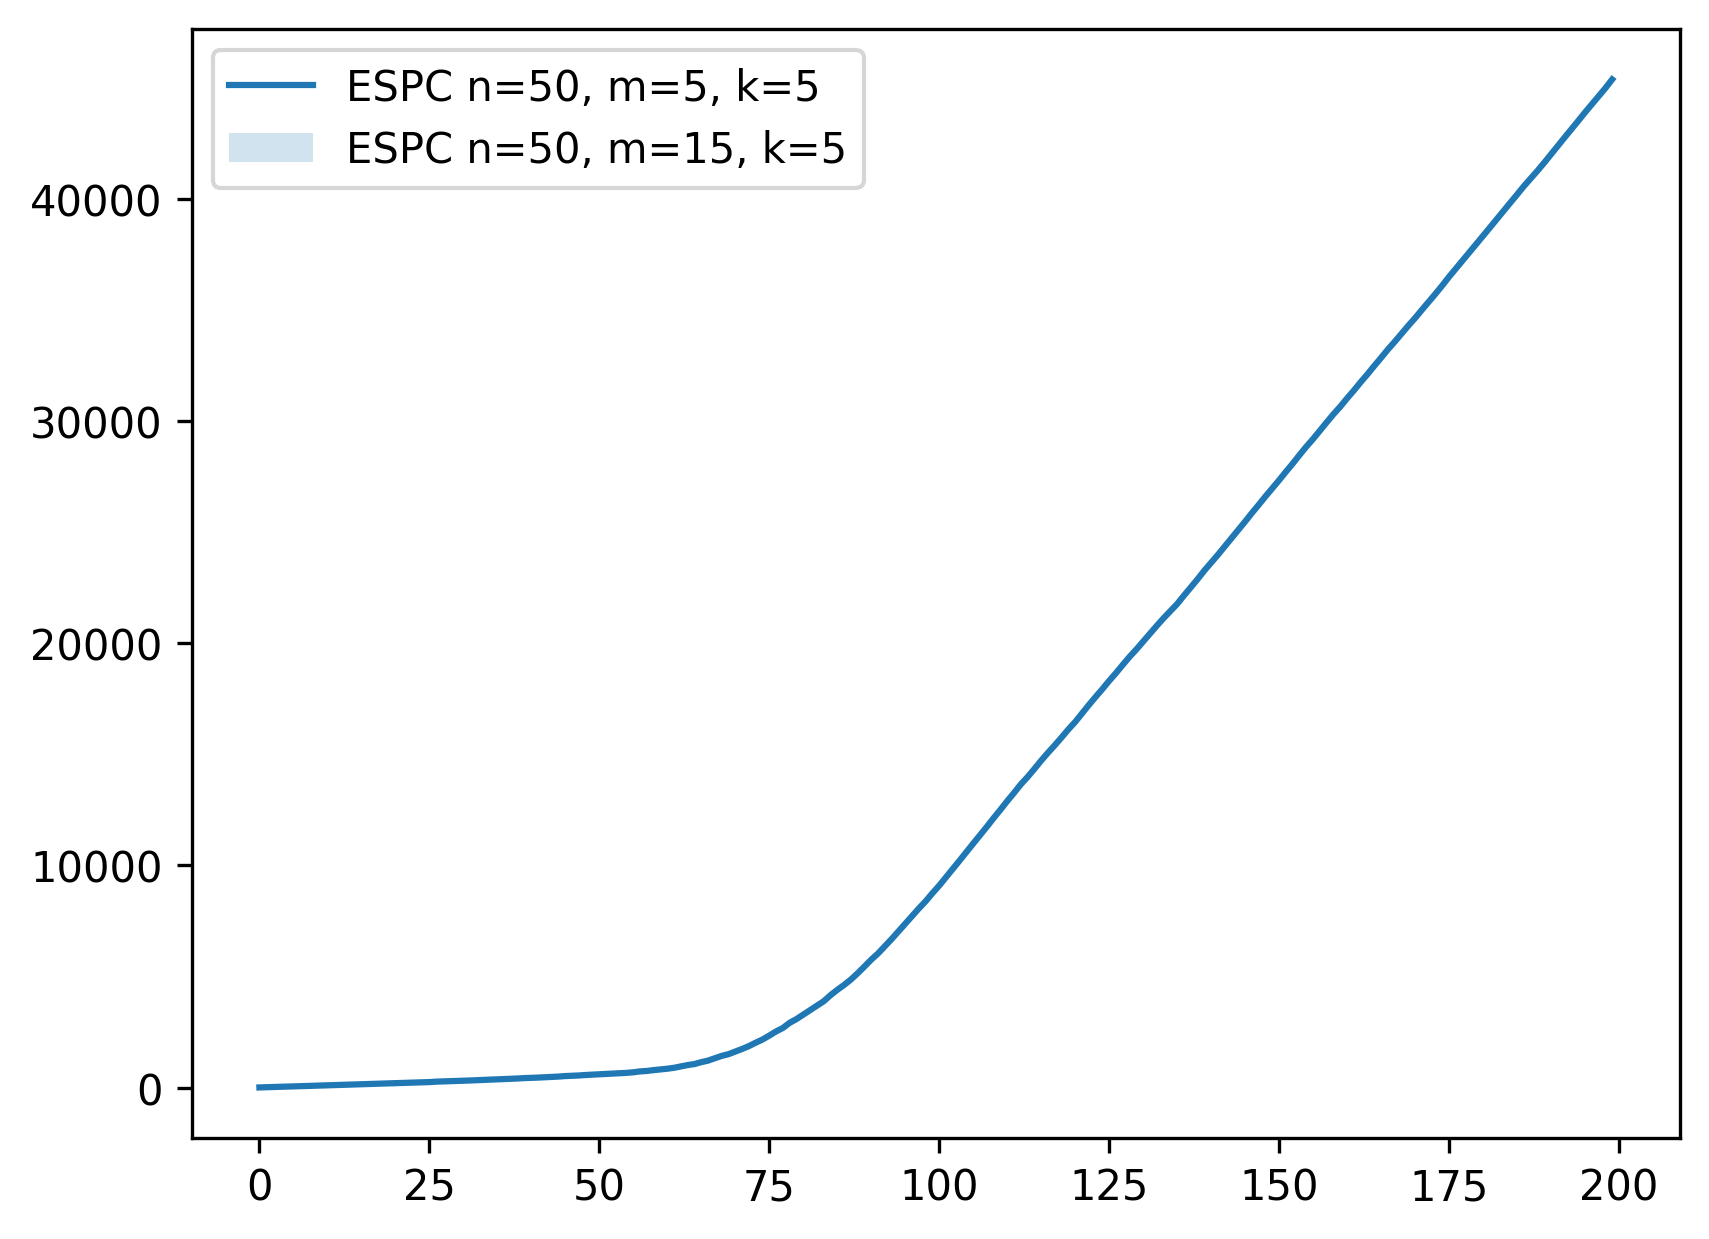

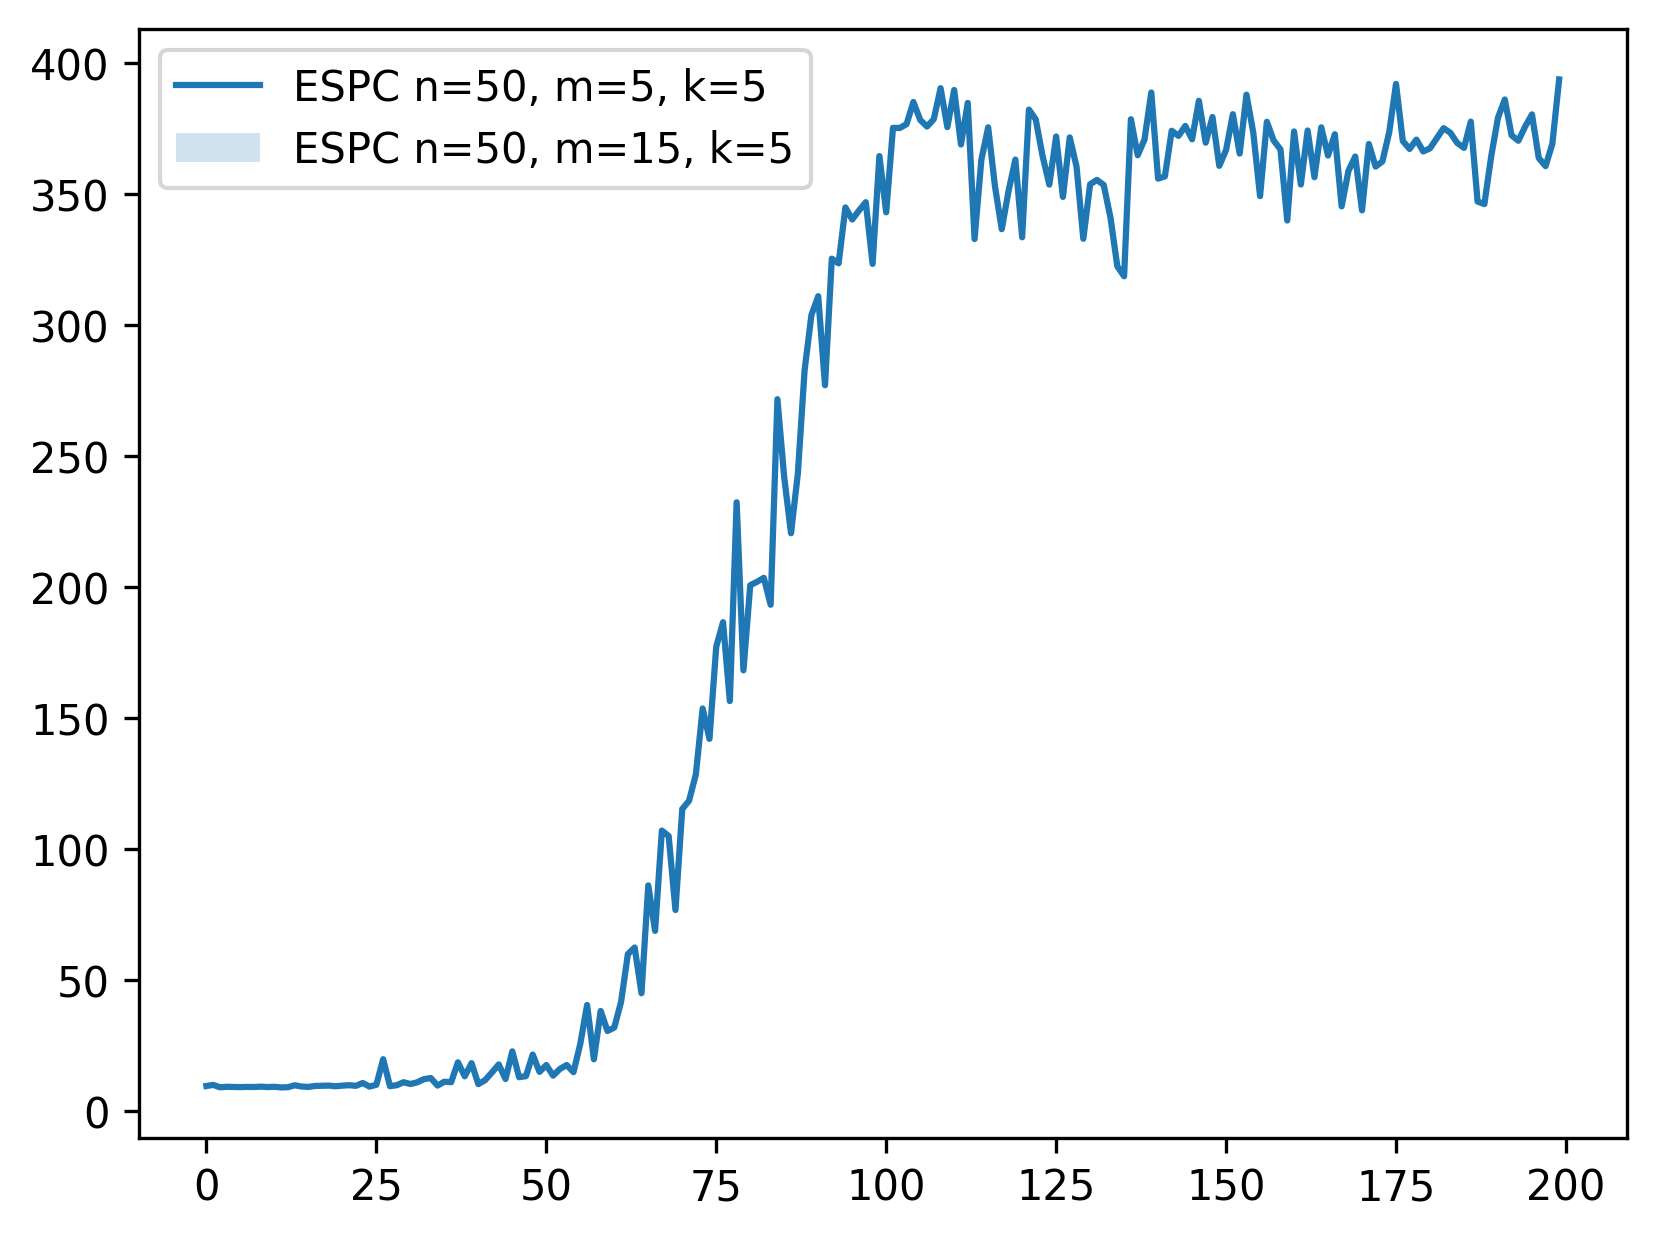

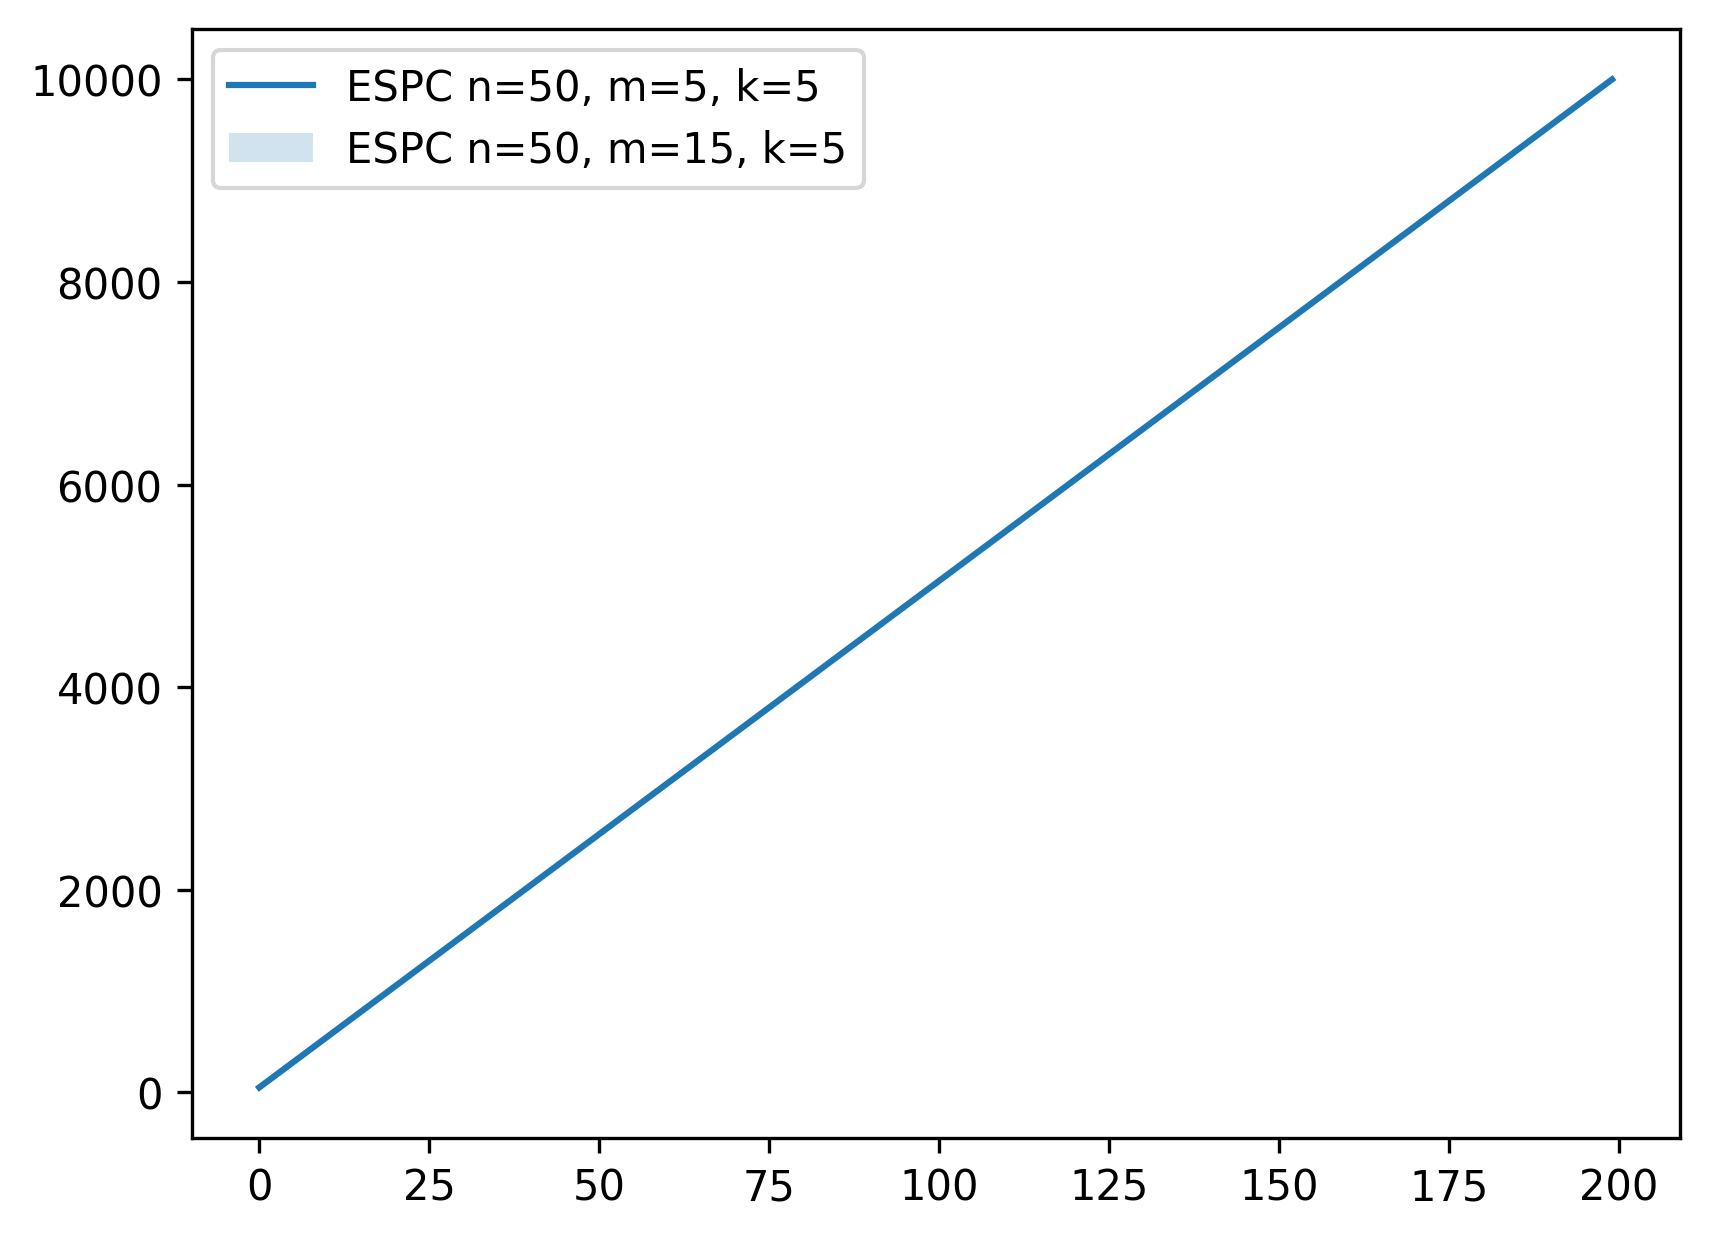

In [60]:
import matplotlib.pyplot as plt

# trial_rewards = np.array(trial_rewards)
trial_mean = np.mean(trial_rewards, axis=0)
trial_perc = np.percentile(trial_rewards, [10,90], axis=0)
cum_trial_perc = np.cumsum(trial_perc, axis=2)

# trial_comms = np.array(trial_comms)
trial_comm_mean = np.cumsum(np.mean(trial_comms, axis=0), axis=1)
trial_comm_perc = np.cumsum(np.percentile(trial_comms, [10,90], axis=0), axis=2)

labels = ["ESPC n=50, m=5, k=5","ESPC n=50, m=15, k=5","ESPC n=50, m=30, k=5","ESPC n=50, m=45, k=5","ES n=50"]
x = range(num_episodes)
plt.figure(dpi=300)
plt.plot(x,np.cumsum(trial_mean, axis=1).T)
for i in range(cum_trial_perc.shape[1]):
    plt.fill_between(x, cum_trial_perc[0,i,:].T, cum_trial_perc[1,i,:].T, alpha=0.2)  
plt.legend(labels)
plt.show()
plt.figure(dpi=300)
plt.plot(x, trial_mean.T)
for i in range(trial_perc.shape[1]):
    plt.fill_between(x, trial_perc[0,i,:].T, trial_perc[1,i,:].T, alpha=0.2)  
plt.legend(labels)
plt.show()
plt.figure(dpi=300)
plt.plot(x,trial_comm_mean.T)
for i in range(trial_comm_perc.shape[1]):
    plt.fill_between(x, trial_comm_perc[0,i,:].T, trial_comm_perc[1,i,:].T, alpha=0.2)  
plt.legend(labels)
plt.show()

